In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Cargando información

In [2]:
laliga2122 = pd.read_excel('LaLiga21 22.xlsx', )
laliga2021 = pd.read_excel('LaLiga20 21.xlsx', )
laliga1920 = pd.read_excel('LaLiga19 20.xlsx', )
laliga1819 = pd.read_excel('LaLiga18 19.xlsx', )
laliga1718 = pd.read_excel('LaLiga17 18.xlsx', )
laliga1617 = pd.read_excel('LaLiga16 17.xlsx', )
seg2122 =  pd.read_excel('LaLiga123 21 22.xlsx', )
seg2021 =  pd.read_excel('LaLiga123 20 21.xlsx', )
seg1920 =  pd.read_excel('LaLiga123 19 20.xlsx', )
seg1819 =  pd.read_excel('LaLiga123 18 19.xlsx', )
seg1718 =  pd.read_excel('LaLiga123 17 18.xlsx', )
seg1617 =  pd.read_excel('LaLiga123 16 17.xlsx', )

In [3]:
laliga = laliga2122.dropna(how='all').append(laliga2021.dropna(how='all')
).append(laliga1920.dropna(how='all')).append(laliga1819.dropna(how='all')
).append(laliga1718.dropna(how='all')).append(laliga1617.dropna(how='all')).loc[:,
['Wk','Date','Local','Score','Visitante', 'Attendance']]

segunda = seg2122.dropna(how='all').append(seg2021.dropna(how='all')
).append(seg1920.dropna(how='all')).append(seg1819.dropna(how='all')
).append(seg1718.dropna(how='all')).append(seg1617.dropna(how='all')).loc[:,
['Wk','Date','Local','Score','Visitante', 'Attendance']]


laliga['Attendance']= laliga['Attendance']*1000
laliga['Torneo'] = 'Primera división'
segunda['Attendance']= segunda['Attendance']*1000
segunda['Torneo'] = 'Segunda división'

In [4]:
partidos6t = pd.concat([laliga,segunda],axis = 0)
partidos6t

,Wk,Date,Local,Score,Visitante,Attendance,Torneo
0,1.0,2021-08-13,Valencia,1–0,Getafe,9868.0,Primera división
1,1.0,2021-08-14,Cádiz,1–1,Levante,6941.0,Primera división
2,1.0,2021-08-14,Mallorca,1–1,Betis,6279.0,Primera división
3,1.0,2021-08-14,Osasuna,0–0,Espanyol,6715.0,Primera división
4,1.0,2021-08-14,Alavés,1–4,Real Madrid,3968.0,Primera división
...,...,...,...,...,...,...,...
495,42.0,2017-06-10,Valladolid,1–0,Cádiz,12812.0,Segunda división
496,42.0,2017-06-10,Gimnàstic,1–0,UCAM Murcia,11103.0,Segunda división
497,42.0,2017-06-10,Alcorcón,3–0,Lugo,4262.0,Segunda división
498,42.0,2017-06-10,Córdoba,2–1,Girona,8977.0,Segunda división


In [5]:
partidos6t['Attendance'] = partidos6t['Attendance'].fillna(0)

In [6]:
def golesvisita(marcador):
    goles = marcador.split('–')
    return int(goles[1])
def goleslocal(marcador):
    goles = marcador.split('–')
    return int(goles[0])

partidos6t['Goles Local'] = partidos6t['Score'].apply(goleslocal)
partidos6t['Goles Visitante'] = partidos6t['Score'].apply(golesvisita)
partidos6t['Total goles partido']= partidos6t['Goles Local']+partidos6t['Goles Visitante']



In [7]:
def torneo(año,mes):
    if ((año==2016) & (mes<=12)|(año==2017) & (mes<8)):
        return '16/17'
    elif ((año==2017) & (mes<=12)|(año==2018) & (mes<8)):
        return '17/18'
    elif ((año==2018) & (mes<=12)|(año==2019) & (mes<8)):
        return '18/19'
    elif ((año==2019) & (mes<=12)|(año==2020) & (mes<9)):
        return '19/20'
    elif ((año==2020) & (mes<=12)|(año==2021) & (mes<8)):
        return '20/21'
    elif ((año==2021) & (mes<=12)|(año==2022) & (mes<8)):
        return '21/22'

    
partidos6t['Año'] = partidos6t['Date'].dt.year
partidos6t['Mes'] = partidos6t['Date'].dt.month
partidos6t['Temporada'] = partidos6t.apply(lambda x: torneo(x['Año'],x['Mes']),axis = 1)

In [8]:
def resultado(string):
    goles = string.split('–')
    if int(goles[0])>int(goles[1]):
        return 'Local'
    if int(goles[0])<int(goles[1]):
        return 'Visitante'
    else: 
        return 'Empate'
    
def resultado_equipo(string, local, visita):
    goles = string.split('–')
    if int(goles[0])>int(goles[1]):
        return local
    if int(goles[0])<int(goles[1]):
        return visita
    else: 
        return 'Empate'
    
partidos6t['Resultado'] = partidos6t['Score'].apply(resultado)
partidos6t['Ganador'] = partidos6t.apply(lambda x: resultado_equipo(x['Score'],x['Local'],x['Visitante']),axis=1)

Hagamos una segmentación de los equipos de la liga española, 1ra y 2da, en cuanto a puntos totales, goles totales, y puntos obtenidos de visita.

# Creando dataframes para agrupación

In [9]:
def puntos(data,torneo,equipos):
    punt = {}
    for equipo in equipos:
        data_usar = data[(((data['Local']==equipo)|(data['Visitante']==equipo))&(data['Torneo']==torneo))]
        puntos = 0
        for i in range(len(data_usar)):
            ganador = str(data_usar.iloc[i]['Ganador'])
            if ganador == equipo:
                puntos += 3
            if ganador == 'Empate':
                puntos +=1
        punt[equipo] = puntos
            
    return punt


def puntos_vis(data,torneo,equipos):
    punt = {}
    for equipo in equipos:
        data_usar = data[(data['Visitante']==equipo)&(data['Torneo']==torneo)]
        puntos = 0
        for i in range(len(data_usar)):
            ganador = str(data_usar.iloc[i]['Ganador'])
            if ganador == equipo:
                puntos += 3
            if ganador == 'Empate':
                puntos +=1
        punt[equipo] = puntos
            
    return punt   

In [10]:
equipos_prim = partidos6t[partidos6t['Torneo']=='Primera división']['Local'].unique().tolist()
equipos_seg = partidos6t[partidos6t['Torneo']=='Segunda división']['Local'].unique().tolist()
primera = puntos(partidos6t, 'Primera división',equipos_prim)
segunda = puntos(partidos6t, 'Segunda división',equipos_seg)

In [11]:
primera_pvis = puntos_vis(partidos6t, 'Primera división',equipos_prim)
segunda_pvis = puntos_vis(partidos6t, 'Segunda división',equipos_seg)

In [12]:
df_prim = pd.DataFrame([[key, primera[key]] for key in primera.keys()], columns=['Equipo', 'Puntos'])
df_prim = df_prim.sort_values(by='Puntos',ascending = False).reset_index(drop=True)

df_seg = pd.DataFrame([[key, segunda[key]] for key in segunda.keys()], columns=['Equipo', 'Puntos'])
df_seg = df_seg.sort_values(by='Puntos',ascending = False).reset_index(drop=True)

In [13]:
df_prim_pvis = pd.DataFrame([[key, primera_pvis[key]] for key in primera_pvis.keys()], columns=['Equipo', 'Puntos'])
df_prim_pvis = df_prim_pvis.sort_values(by='Puntos',ascending = False).reset_index(drop=True)

df_seg_pvis = pd.DataFrame([[key, segunda_pvis[key]] for key in segunda_pvis.keys()], columns=['Equipo', 'Puntos'])
df_seg_pvis = df_seg_pvis.sort_values(by='Puntos',ascending = False).reset_index(drop=True)

## Juntando dataframes

In [14]:
prim = df_prim.merge(df_prim_pvis, on='Equipo').set_axis(['Equipo','Puntos total','Puntos visita'],axis=1)
seg = df_seg.merge(df_seg_pvis, on='Equipo').set_axis(['Equipo','Puntos total','Puntos visita'],axis=1)

In [15]:
test1 = partidos6t[partidos6t['Torneo']=='Primera división'].groupby('Local')['Goles Local'].sum().reset_index()
test1 = test1.rename(columns={"Local": "Equipo", 'Goles Local': 'Goles de local'})

test2 = partidos6t[partidos6t['Torneo']=='Primera división'].groupby('Visitante')['Goles Visitante'].sum().reset_index()
test2 = test2.rename(columns = {'Goles Visitante': 'Goles de visitante'})

result = pd.concat([test1, test2], axis=1)
dt = result.drop(['Visitante'], axis=1)
dt['Goles totales'] = (dt['Goles de local'] + dt['Goles de visitante'])
dt = dt[['Equipo','Goles totales']]

In [16]:
test1_seg = partidos6t[partidos6t['Torneo']=='Segunda división'].groupby('Local')['Goles Local'].sum().reset_index()
test1_seg = test1_seg.rename(columns={"Local": "Equipo", 'Goles Local': 'Goles de local'})

test2_seg = partidos6t[partidos6t['Torneo']=='Segunda división'].groupby('Visitante')['Goles Visitante'].sum().reset_index()
test2_seg = test2_seg.rename(columns = {'Goles Visitante': 'Goles de visitante'})

result_seg = pd.concat([test1_seg, test2_seg], axis=1)
dt_seg = result_seg.drop(['Visitante'], axis=1)
dt_seg['Goles totales'] = (dt_seg['Goles de local']+dt_seg['Goles de visitante'])
dt_seg = dt_seg[['Equipo','Goles totales']]

In [17]:
df_primera = prim.merge(dt,on='Equipo')
df_segunda = seg.merge(dt_seg,on='Equipo')

In [18]:
df_primera

,Equipo,Puntos total,Puntos visita,Goles totales
0,Barcelona,504,231,544
1,Real Madrid,494,233,480
2,Atlético Madrid,460,195,366
3,Sevilla,406,161,340
4,Villarreal,349,155,348
5,Real Sociedad,343,149,325
6,Valencia,324,126,316
7,Betis,316,130,305
8,Athletic Club,311,112,265
9,Celta Vigo,271,103,300


In [19]:
df_segunda

,Equipo,Puntos total,Puntos visita,Goles totales
0,Almería,367,145,316
1,Oviedo,355,127,294
2,Tenerife,347,140,283
3,Zaragoza,337,144,287
4,Lugo,299,105,254
5,Sporting Gijón,297,111,223
6,Alcorcón,279,120,220
7,Girona,270,99,216
8,Cádiz,261,110,200
9,Huesca,259,98,215


## Agrupación primera división

In [20]:
eqprim_nombres = df_primera[['Equipo']]
df_primera1 = df_primera[['Puntos total', 'Puntos visita', 'Goles totales']]

In [21]:
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df_primera1)
df_escalado = pd.DataFrame(df_escalado) 
df_escalado = df_escalado.rename(columns = {0: 'Puntos Total', 1: 'Puntos visita', 2:'Goles totales'}) 
df_escalado

,Puntos Total,Puntos visita,Goles totales
0,1.000000,0.990950,1.000000
1,0.978858,1.000000,0.872510
2,0.906977,0.828054,0.645418
3,0.792812,0.674208,0.593625
4,0.672304,0.647059,0.609562
5,0.659619,0.619910,0.563745
6,0.619450,0.515837,0.545817
7,0.602537,0.533937,0.523904
8,0.591966,0.452489,0.444223
9,0.507400,0.411765,0.513944


In [22]:
x = df_escalado['Puntos Total'].values
y = df_escalado['Puntos visita'].values
z = df_escalado['Goles totales'].values

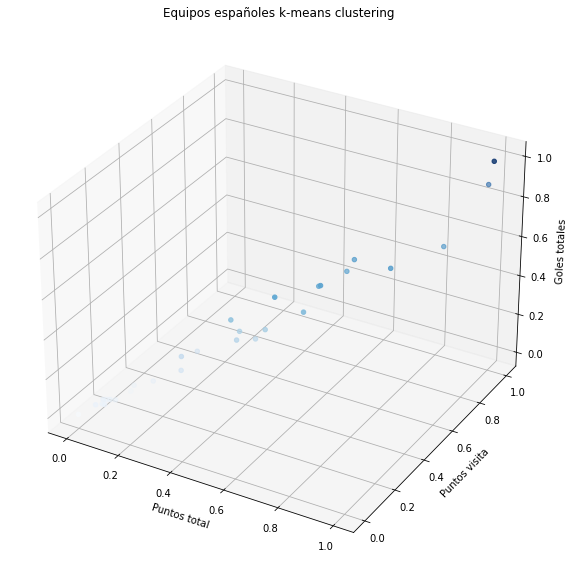

In [23]:
fig = plt.figure(figsize = (20, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='Blues');
ax.set_xlabel("Puntos total")
ax.set_ylabel("Puntos visita")
ax.set_zlabel("Goles totales")
plt.title('Equipos españoles k-means clustering')
plt.show()

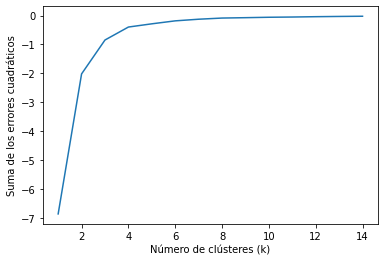

In [24]:
nc = range(1, 15) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

In [25]:
kmeans = KMeans(n_clusters=4).fit(df_escalado)
centroids = kmeans.cluster_centers_
centroids

array([[0.08802614, 0.07075278, 0.06772908],
       [0.63515554, 0.55074337, 0.54211725],
       [0.37130021, 0.31108597, 0.30129482],
       [0.96194503, 0.93966817, 0.83930943]])

In [26]:
labels = kmeans.predict(df_escalado)
df_primera1['label'] = labels

In [27]:
df_primera1['Equipo'] = eqprim_nombres

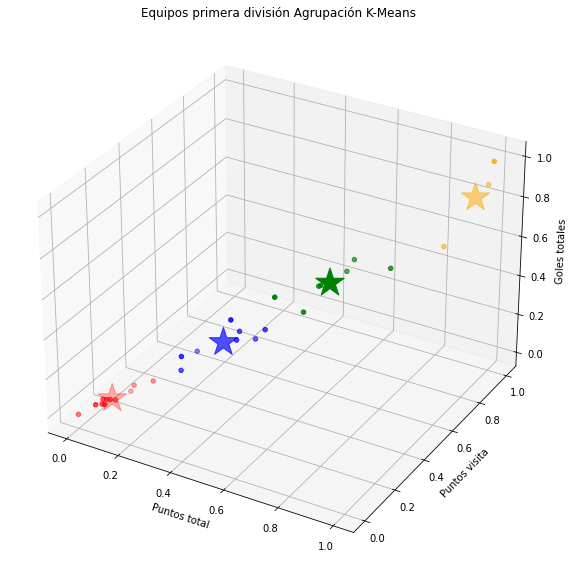

In [28]:
colores=['red','green','blue','orange']
asignar=[]
for row in labels:
     asignar.append(colores[row])
fig = plt.figure(figsize = (20, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=asignar)
ax.scatter3D(centroids[:, 0], centroids[:, 1],centroids[:, 2], marker = '*',c=['red','green','blue','orange'], 
            s=900)
ax.set_xlabel("Puntos total")
ax.set_ylabel("Puntos visita")
ax.set_zlabel("Goles totales")
plt.title('Equipos primera división Agrupación K-Means')
plt.show()

In [29]:
df_primera1

,Puntos total,Puntos visita,Goles totales,label,Equipo
0,504,231,544,3,Barcelona
1,494,233,480,3,Real Madrid
2,460,195,366,3,Atlético Madrid
3,406,161,340,1,Sevilla
4,349,155,348,1,Villarreal
5,343,149,325,1,Real Sociedad
6,324,126,316,1,Valencia
7,316,130,305,1,Betis
8,311,112,265,1,Athletic Club
9,271,103,300,1,Celta Vigo


## Agrupación Equipos de segunda división

In [30]:
eqseg_nombres = df_segunda[['Equipo']]
df_segunda1 = df_segunda[['Puntos total', 'Puntos visita', 'Goles totales']]

In [31]:
min_max_scaler1 = preprocessing.MinMaxScaler() 
df_escalado1 = min_max_scaler1.fit_transform(df_segunda1)
df_escalado1 = pd.DataFrame(df_escalado1) 
df_escalado1 = df_escalado1.rename(columns = {0: 'Puntos Total', 1: 'Puntos visita', 2:'Goles totales'}) 

In [32]:
x1 = df_escalado1['Puntos Total'].values
y1 = df_escalado1['Puntos visita'].values
z1 = df_escalado1['Goles totales'].values

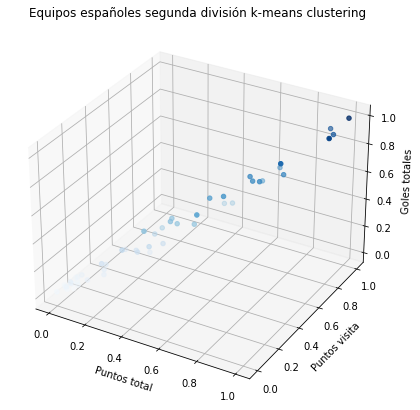

In [33]:
fig = plt.figure(figsize = (13, 7))
ax = plt.axes(projection='3d')
ax.scatter3D(x1, y1, z1, c=z1, cmap='Blues');
ax.set_xlabel("Puntos total")
ax.set_ylabel("Puntos visita")
ax.set_zlabel("Goles totales")
plt.title('Equipos españoles segunda división k-means clustering')
plt.show()

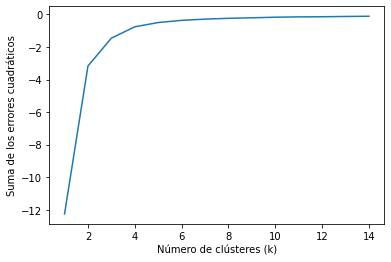

In [34]:
nc2 = range(1, 15) 
kmeans2 = [KMeans(n_clusters=i) for i in nc2]
score2 = [kmeans2[i].fit(df_escalado1).score(df_escalado1) for i in range(len(kmeans2))]
score2
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc2,score2)

In [35]:
kmeans2 = KMeans(n_clusters=4).fit(df_escalado1)
centroids2 = kmeans2.cluster_centers_
centroids2

array([[0.0594075 , 0.10071942, 0.06834795],
       [0.66004355, 0.67495095, 0.61142677],
       [0.33453094, 0.35779376, 0.32384259],
       [0.95359281, 0.95683453, 0.92708333]])

In [36]:
labels2 = kmeans2.predict(df_escalado1)
df_segunda1['label'] = labels2

In [37]:
df_segunda1['Equipo'] = eqseg_nombres

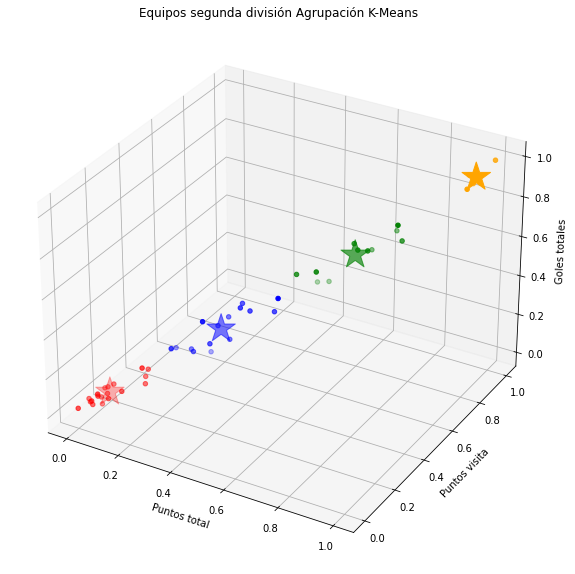

In [38]:
colores=['red','green','blue','orange']
asignar2=[]
for row in labels2:
     asignar2.append(colores[row])
fig2 = plt.figure(figsize = (20, 10))
ax2 = plt.axes(projection='3d')
ax2.scatter3D(x1, y1, z1, c=asignar2)
ax2.scatter3D(centroids2[:, 0], centroids2[:, 1],centroids2[:, 2], marker = '*',c=['red','green','blue','orange'], 
            s=900)
ax2.set_xlabel("Puntos total")
ax2.set_ylabel("Puntos visita")
ax2.set_zlabel("Goles totales")
plt.title('Equipos segunda división Agrupación K-Means')
plt.show()

In [39]:
df_segunda1

,Puntos total,Puntos visita,Goles totales,label,Equipo
0,367,145,316,3,Almería
1,355,127,294,3,Oviedo
2,347,140,283,3,Tenerife
3,337,144,287,3,Zaragoza
4,299,105,254,1,Lugo
5,297,111,223,1,Sporting Gijón
6,279,120,220,1,Alcorcón
7,270,99,216,1,Girona
8,261,110,200,1,Cádiz
9,259,98,215,1,Huesca
